<p align="center">
    <!--If notebook is in folder notebooks change scr by "../images/logo.png"-->
  <img width="100" height="100" src="../images/logo.png">
</p>

<div>
<h1>04. Modelos C_SEV</h1> 

Canadian Car Accidents Practice <br>
<strong>Aprendizaje Automático</strong> <br>
<strong>Master Universitario en Ciencia de Datos</strong>
</div>

<div style='text-align:right'>Álvaro Serrano del Rincón (<i>a.serranodelrincon@cunef.edu</i>)</div>
<div style='text-align:right'>Carlos Viñals Guitart (<i>carlos.vinals@cunef.edu</i>)</div>

---


## 4.0 Introducción

En este notebook creamos distintos modelos y realizamos una evaluación de los mismos con el objetivo de encontrar el que mejor permita clasificar los accidentes. 

Para este trabajo estamos utilizando un entorno de propósito espécifico.

In [1]:
!conda info


     active environment : ML_P1
    active env location : C:\Users\carviagu\anaconda3\envs\ML_P1
            shell level : 2
       user config file : C:\Users\carviagu\.condarc
 populated config files : 
          conda version : 4.10.3
    conda-build version : 3.21.4
         python version : 3.8.8.final.0
       virtual packages : __cuda=11.3=0
                          __win=0=0
                          __archspec=1=x86_64
       base environment : C:\Users\carviagu\anaconda3  (writable)
      conda av data dir : C:\Users\carviagu\anaconda3\etc\conda
  conda av metadata url : None
           channel URLs : https://repo.anaconda.com/pkgs/main/win-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/win-64
                          https://repo.anaconda.com/pkgs/r/noarch
                          https://repo.anaconda.com/pkgs/msys2/win-64
                          https://repo.anaconda.com/pkgs/msys2/no

### 4.0.1 Estructura
0. Librerías y scripts
1. Datos
2. Modelado
    - Modelo base
    - Modelo GLM
    - Modelo SVM
    - Modelo Random Forest 
    - Modelo XGBoost
    - Modelo LightGBM
4. Valoración
5. Elección y conclusiones

## Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import nbconvert

# MÉTRICAS
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, fbeta_score

# MODELOS
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import lightgbm
from xgboost import XGBClassifier

## Scripts

In [3]:
import sys

import sys  
sys.path.insert(0, '../scripts/')

import csv_tools
import model_tools

## 4.1 Datos
Para desarrollar este modelo básico haremos uso de los datos sin tratamiento alguno, pues nuestro objetivo es tener un punto de partida que permita valorar las mejoras realizadas con los modelos tratados. 

Por lo tanto leeremos los datos directamente:

In [4]:
full_train = pd.read_csv("../data/csev/fulltrainCSEVscal.csv")
full_test = pd.read_csv("../data/csev/fulltestCSEVscal.csv")

In [5]:
Y_train = full_train['C_SEV']
X_train = full_train.drop(['C_SEV'], axis=1)
Y_train.value_counts()

0    27794
1    27794
Name: C_SEV, dtype: int64

In [6]:
Y_test = full_test['C_SEV']
X_test = full_test.drop(['C_SEV'], axis=1)
Y_test.value_counts()

1    351139
0      6949
Name: C_SEV, dtype: int64

## 4.2 Modelado

A continuación probaremos distintos modelos con el objetivo de encontrar el más adecuado para solventar el problema en el que nos encontramos. En concreto haremos uso de 5 modelos:
* GLM (Logistic Regression)
* SVM
* Random Forest
* XGBBoost
* LightGBM

Adicionalmente tendremos un modelo base, como punto de partida para comparar las métricas.

**Métricas de evaluación**

Para poder compara los modelos haremos uso de métricas de valoración. Al encontrarnos con un problema drásticamente desbalanceado, resulta muy complicado hacer uso de la mayoría de métricas disponibles. Por ello haremos uso de la matriz de confusión normalizada y de las métricas de *precission* y *recall* que permitirán analizar en detalle si el modelo es adecuado. 

Si bien se calculará para poder comparar en algunos casos, no hacemos uso de métricas como el *accuracy* para determinar que modeo es mejor, pues este puede ser elevado acertando la clase mayoritaria pero fallando de manera considerable la clase minoritaria. Podremos observar esta situación con el modelo base que calcularemos a continuación.

In [14]:
# Diccionario para guardar las predicciones realizadas por cada modelo
predictions = {}
models = {}

### 4.2.1 Modelo base
El modelo base utiliza el algoritmo de la clase mayoritaria, es decir, asginará a las predicciones el valor mayoritario del conjunto de la muestra. En nuestro caso no fallecidos (1).

In [16]:
Y_pred = pd.Series(data = [1] * len(Y_test), index = Y_test.index)

In [17]:
predictions['Base'] = Y_pred

#### Evaluación

In [18]:
model_tools.accuracy(Y_test, Y_pred)

0.98059415562655

Matriz de confusión
[[     0   6949]
 [     0 351139]]
Matriz de confusión normalizada
[[0. 1.]
 [0. 1.]]


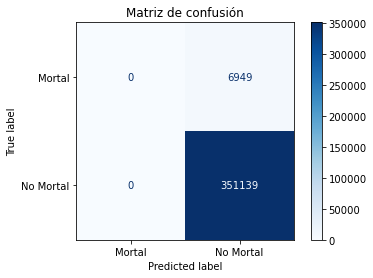

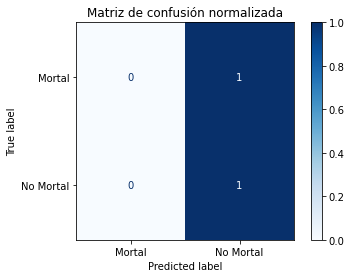

In [19]:
titles_options = [
    ("Matriz de confusión", None),
    ("Matriz de confusión normalizada", "true"),
]

model_tools.confusion_matrix(titles_options, Y_test, Y_pred, 
                            ['Mortal', 'No Mortal'])

El modelo base se limita a afirmar que, la predicción de nuevas observaciones será de la clase mayoritaria. En este caso, la clase mayoritaria es que no habrá accidentes mortales, por lo que según el modelo no habrá accidentes mortales. 

### 4.2.2 Modelo GLM 

Ref: https://towardsdatascience.com/generalized-linear-models-9cbf848bb8ab

Se trata de un modelo lineal de Machine Learning que emplea la función logística como clasificador. Este modelo se emplea para predecir valores de una variable continua (y) como una combinación lineal de la variable x. Un modelo GLM está compuesto por tres partes: un **predictor lineal**, una **función de link** y una **función de probabilidad** (por ejemplo la Poisson).

Para este modelo GLM, utilizaremos como clasificador un Regresor Logístico.

In [20]:
model = LogisticRegression()

In [21]:
model.fit(X_train, Y_train)

LogisticRegression()

In [22]:
Y_pred = model.predict(X_test)

In [23]:
predictions['GLM'] = Y_pred
models['GLM'] = model

In [24]:
file_name = "../models/glm_model.sav"
pickle.dump(model, open(file_name, "wb"))

#### Evaluación

In [25]:
model_tools.accuracy(Y_test, Y_pred)

0.6030612586850159

Matriz de confusión
[[  4888   2061]
 [140078 211061]]
Matriz de confusión normalizada
[[0.70341056 0.29658944]
 [0.39892464 0.60107536]]


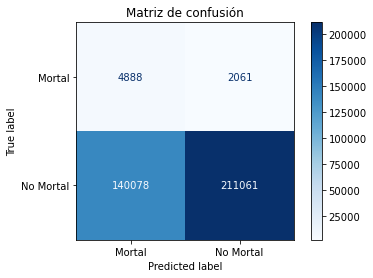

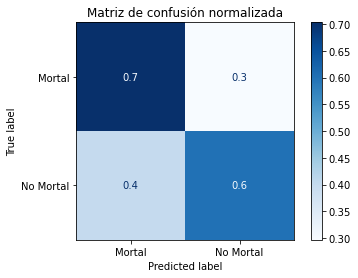

In [26]:
titles_options = [
    ("Matriz de confusión", None),
    ("Matriz de confusión normalizada", "true"),
]
model_tools.confusion_matrix(titles_options, Y_test, Y_pred, 
                            ['Mortal', 'No Mortal'])

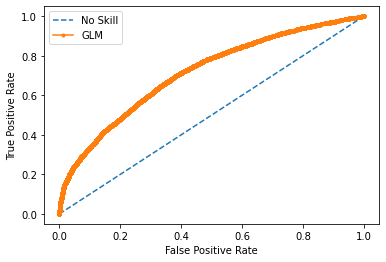

In [27]:
pred_prob = model.predict_proba(X_test)[:,1]
model_tools.roc_curve(Y_test, pred_prob, 'GLM')

Se observa que se mejora notablemente los resultados del modelo base, alcanzando un 70% de precisión a la hora de predecir los accidentes con fallecidos, y un 60% de los accidentes no mortales. 

Cabe mencionar que, con un dataset tan desequilibrado, no debemos guiarnos por el accuracy de los modelos a la hora de compararlos (porque favorecen a la clase mayoritaria), sino más por la matriz de confusión normalizada y la curva ROC.

### 4.2.3 Modelo SVM

Ref: https://towardsdatascience.com/support-vector-machines-svm-c9ef22815589

El SVM (Support Vector Machine) es un algoritmo de aprendizaje automático no supervisado, que puede ser utilizado tanto como clasificador (SVC. Support Vector Classifier) como regresor (SVR. Support Vector Regressor). 

En este caso, nos centraremos en el **SVC**, que trata de encontrar un hiperplano que pueda separar las dos categorías: accidentes mortales y accidentes sin muertos. Es por ello que se trata de un algoritmo muy pesado y que requiere mucho tiempo de cálculo, pues tiene que probar todas las combinaciones posibles de planos para separar las variables objetivo. 

In [28]:
svc = SVC(gamma = 'auto')

In [29]:
svc.fit(X_train, Y_train)

SVC(gamma='auto')

In [30]:
Y_pred = svc.predict(X_test)

In [31]:
predictions['SVM'] = Y_pred
models['SVM'] = model

In [32]:
file_name = "../models/svm_model.sav"
pickle.dump(model, open(file_name, "wb"))

#### Evaluación

In [33]:
model_tools.accuracy(Y_test, Y_pred)

0.6570200621076383

Matriz de confusión
[[  4809   2140]
 [120677 230462]]
Matriz de confusión normalizada
[[0.69204202 0.30795798]
 [0.34367302 0.65632698]]


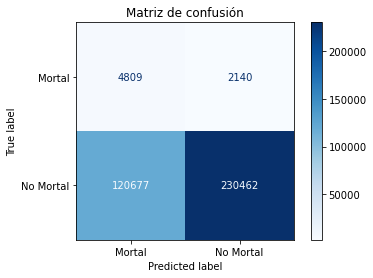

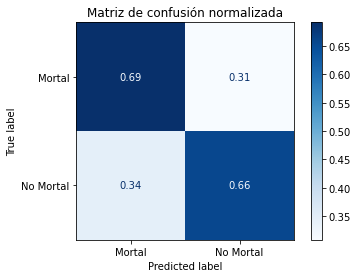

In [34]:
titles_options = [
    ("Matriz de confusión", None),
    ("Matriz de confusión normalizada", "true"),
]
model_tools.confusion_matrix(titles_options, Y_test, Y_pred, 
                           ['Mortal', 'No Mortal'])

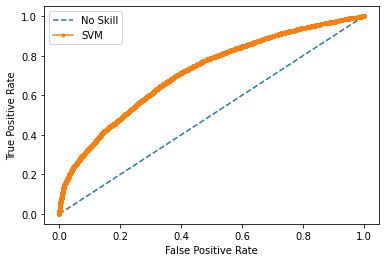

In [35]:
pred_prob = model.predict_proba(X_test)[:,1]
model_tools.roc_curve(Y_test, pred_prob, 'SVM')

Los resultados de este modelo están más equilibrados que en el GLM, acertando casi un 70% de las veces los accidentes mortales, y un 66% los no mortales. No obstante, dicho modelo es mucho más pesado, y ha requerido mucho tiempo de computación para poder mostrar los resultados. 

### 4.2.4 Modelo RandomForest

Ref: https://towardsdatascience.com/understanding-random-forest-58381e0602d2

El Random Forest consiste en una serie de árboles de decisión que funcionan de manera conjunta, en el que cada **decision tree** aporta una predicción, de manera que la clase que haya sido la predicción de más modelos, se convertirá en la predicción del modelo. 

Los Random Forests han mostrado ser muy efectivos, debido a la poca correlación existente entre cada uno de los árboles, pues ello implica que los errores de cada árbol no estén correlacionados, es decir, que no se está dejando por explicar la información del modelo. 

In [36]:
model = RandomForestClassifier()

In [37]:
model.fit(X_train, Y_train)

RandomForestClassifier()

In [38]:
Y_pred = model.predict(X_test)

In [39]:
predictions['Random Forest'] = Y_pred
models['Random Forest'] = model

In [40]:
file_name = "../models/rf_model.sav"
pickle.dump(model, open(file_name, "wb"))

#### Evaluación

In [41]:
model_tools.accuracy(Y_test, Y_pred)

0.6338749134291012

Matriz de confusión
[[  4802   2147]
 [128958 222181]]
Matriz de confusión normalizada
[[0.69103468 0.30896532]
 [0.36725627 0.63274373]]


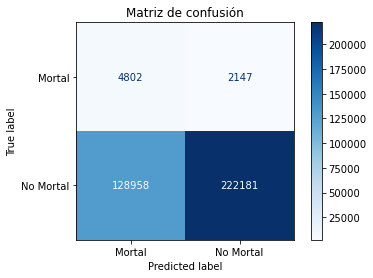

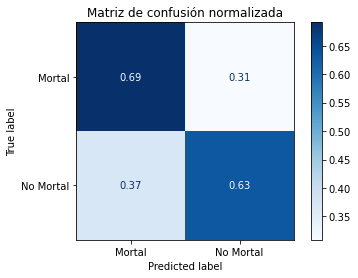

In [42]:
titles_options = [
    ("Matriz de confusión", None),
    ("Matriz de confusión normalizada", "true"),
]
model_tools.confusion_matrix(titles_options, Y_test, Y_pred, 
                            ['Mortal', 'No Mortal'])

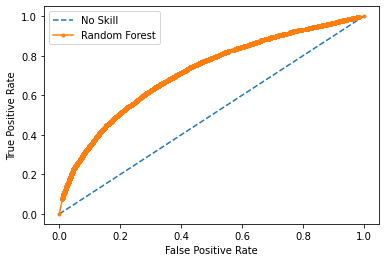

In [43]:
pred_prob = model.predict_proba(X_test)[:,1]
model_tools.roc_curve(Y_test, pred_prob, 'Random Forest')

El Random Forest muestra unas predicciones menos precisas que el SVM (prestando atención a la matriz de confusión), aunque con un tiempo de ejecución mucho menor. No obstante, no parece que vaya a ser el modelo más apropiado.

### 4.2.5 Modelo XGBBoost

Ref: https://towardsdatascience.com/xgboost-theory-and-practice-fb8912930ad6

Es un algoritmo supervisado de machine learning, dentro de los modelos de gradient boosting trees. Esto significa que es un modelo de árbol, al igual que el Random Forest, pero a diferencia de este, el XGBoost (eXtreme Gradient Boosting) es un algoritmo de boosting, que se encarga de combinar varios modelos en uno, pues realiza la predicción basándose secuencialmente en la decisión en el error de la predicción anterior.

De esta manera, el modelo busca minimizar el error de la función (mediante derivadas), aproximandose al mínimo de la misma de forma secuencial.

In [64]:
model = XGBClassifier(use_label_encoder=False, eval_metric="error") # Default values

In [65]:
model.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='error', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [66]:
Y_pred = model.predict(X_test)

In [67]:
predictions['XGB'] = Y_pred
models['XGB'] = model

In [68]:
file_name = "../models/xgb_model.sav"
pickle.dump(model, open(file_name, "wb"))

#### Evaluación

In [69]:
model_tools.accuracy(Y_test, Y_pred)

0.6577237997363776

Matriz de confusión
[[  4908   2041]
 [120524 230615]]
Matriz de confusión normalizada
[[0.70628867 0.29371133]
 [0.34323729 0.65676271]]


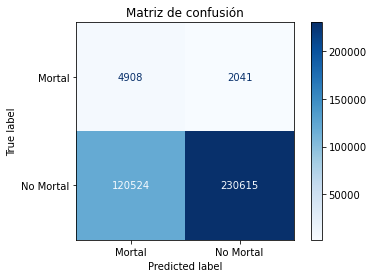

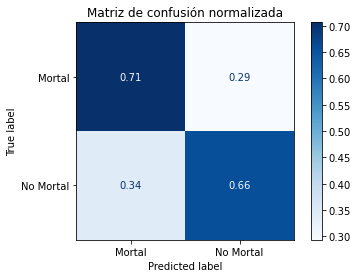

In [70]:
titles_options = [
    ("Matriz de confusión", None),
    ("Matriz de confusión normalizada", "true"),
]
model_tools.confusion_matrix(titles_options, Y_test, Y_pred, 
                            ['Mortal', 'No Mortal'])

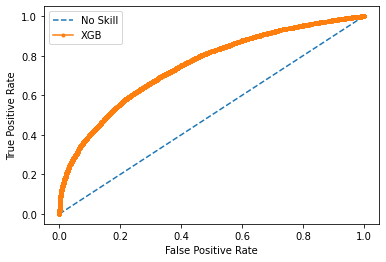

In [71]:
pred_prob = model.predict_proba(X_test)[:,1]
model_tools.roc_curve(Y_test, pred_prob, 'XGB')

El XGBoost es hasta ahora, el modelo que ha arrojado unos mejores resultados, acertando un 71% de las veces a la hora de determinar accidentes mortales, y con un 66% de acierto en los accidentes no mortales, maximizando de esa manera la curva ROC. 

### 4.2.6 Modelo LigthGBM
Ref: https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db

Se trata de otro algoritmo de aprendizaje automático supervisado de boosting trees, de la misma familia que XGBoost. LightGBM fue lanzado por Microsoft en 2017, y se diferencia de XGBoost en que, mientras este último emplea algoritmos pre-clasificados y basados en histogramas para determinar la división óptima, el LightGBM utiliza una técnica más sofisticada llamada **Gradient-based One-Side Sampling (GOSS)** para filtrar los datos y poder encontrar la mejor división posible.

Esta técnica funciona tan bien porque el *gradiente* representa la pendiente de la tangente de la función de pérdida, de modo que si estos gradientes de estos puntos son grandes, ayudan a encontrar el split óptimo, pues tienen un mayor error. En otras palabras, se centra en computar la información que genera un gradient mayor, pues estos juegan un rol más importante a la hora de computar la ganancia de información. 

In [52]:
model = lightgbm.LGBMClassifier()

In [53]:
model.fit(X_train, Y_train)

LGBMClassifier()

In [54]:
Y_pred = model.predict(X_test)

In [55]:
predictions['LightGBM'] = Y_pred
models['LightGBM'] = model

In [56]:
file_name = "../models/lgbm_model.sav"
pickle.dump(model, open(file_name, "wb"))

#### Evaluación

In [57]:
model_tools.accuracy(Y_test, Y_pred)

0.6604298384754586

Matriz de confusión
[[  4893   2056]
 [119540 231599]]
Matriz de confusión normalizada
[[0.70413009 0.29586991]
 [0.34043498 0.65956502]]


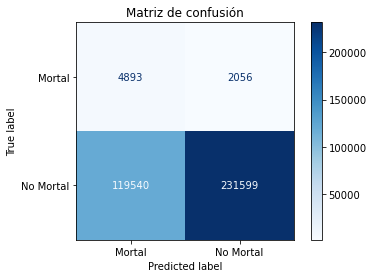

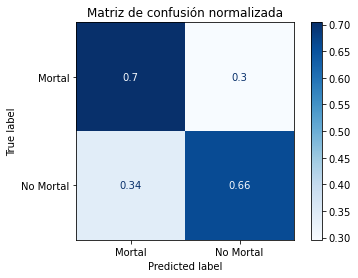

In [58]:
titles_options = [
    ("Matriz de confusión", None),
    ("Matriz de confusión normalizada", "true"),
]
model_tools.confusion_matrix(titles_options, Y_test, Y_pred, 
                            ['Mortal', 'No Mortal'])

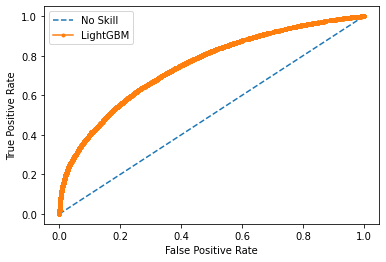

In [59]:
pred_prob = model.predict_proba(X_test)[:,1]
model_tools.roc_curve(Y_test, pred_prob, 'LightGBM')

Los resultados del modelo LightGBM son muy similares a los del XGBoost, si bien muestra un poco menos de precisión a la hora de determinar los accidentes mortales, pero se trata sin duda de un modelo que funciona muy bien, y que maximiza la ROC curve.

## 4.3 Valoración
A continuación, procedemos a valorar los modelos de forma conjunta, para poder escoger el mejor modelo.

Analizamos las curvas ROC de los modelos. Primero, realizamos una representación básica que incluya el modelo base.

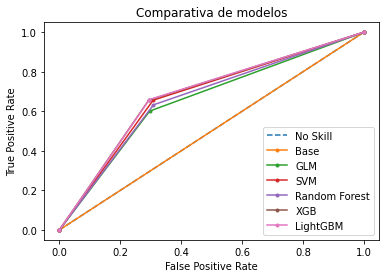

In [60]:
# Curva por defecto
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

# Curva de cada modelo
for key in predictions:
    # calculate roc curves (no prob)
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, predictions[key])
    plt.plot(fpr, tpr, marker='.', label=key)

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparativa de modelos')
plt.legend()

Observamos que el modelo base, es un modelo sin ningún tipo de aprendizaje por lo que su curva es igual a un modelo *No Skill*. Y que los modelos Boost (XGB y LightGBM) presentan unas curvas más próximas a un modelo con un mejor entrenamiento.

Ahora representaremos la curva con probabilidades de predicción.

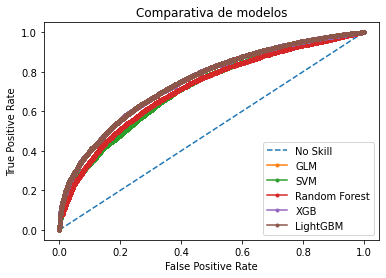

In [61]:
# Curva por defecto
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

# Curva de cada modelo
for key in models:
        yhat = models[key].predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = metrics.roc_curve(Y_test, yhat)
        plt.plot(fpr, tpr, marker='.', label=key)

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparativa de modelos')
plt.legend()

Parece que los modelos Boost (XGBoost y LightGBM) son los mejores, pues maximizan la curva ROC.

Ahora representaremos sus valores de precision y recall.

In [62]:
scores = pd.DataFrame(data = predictions.keys(), columns = ['Models'], index = [0, 1, 2, 3, 4, 5])

pres = list()
rec = list()
roc = list()

for key in predictions:
    # Precision
    pres.append(metrics.precision_score(Y_test, predictions[key], zero_division = 0.0, labels=[0], average='weighted'))
    # Recall
    rec.append(metrics.recall_score(Y_test, predictions[key], zero_division = 0.0, labels=[0], average='weighted'))
    # RocAUC
    if (key == 'Base'):
        roc.append(0.00)
    else:
        roc.append(metrics.roc_auc_score(Y_test, models[key].predict_proba(X_test)[:,1]))

scores['Precision'] = pres
scores['Recall'] = rec
scores['Roc_Auc'] = roc

scores

,Models,Precision,Recall,Roc_Auc
0,Base,0.000000,0.000000,0.000000
1,GLM,0.033718,0.703411,0.715657
2,SVM,0.038323,0.692042,0.715657
3,Random Forest,0.035900,0.691035,0.717462
4,XGB,0.039129,0.706289,0.750746
5,LightGBM,0.039322,0.704130,0.751358


A la hora de valorar los modelos la precision no es muy útil pues el problema está desbalanceado, por lo que haremos uso del recall como métrica principal. Paralelamente utilizamos el ROC_AUC, es decir, el área de la curva ROC, observamos que es ligeramente superior en el LightGBM, pues este es más equilibrado, sin embargo nos interesa que el modelo prediga mejor los accidentes con fallecidos, pues ese es el eje central del modelo, y la clase que es a priori más difícil de pronosticar (por lo desbalanceado que está el dataset).

## 4.4 Elección y conclusiones

#### Modelo seleccionado
En resumen, y a tenor de lo anteriormente explicado, el modelo elegido es el **XGBoost**, pues pese a tener una curva ROC y resultados muy similares al *LightGBM*, el primero acierta más a la hora de predecir la clase minoritaria, lo que ha resultado determinante para poder tomar la decisión. Los demás modelos, pese a arrojar buenos resultados, se encuentran un paso por detrás de los modelos de boosting. 

#### Siguientes pasos
A continuación, y una vez que se ha elegido (basándonos en las métricas, pero con un componente subjetivo) el modelo más adecuado, es el momento de afinarlo para poder mejorar tanto la precisión como el recall de las predicciones. En el notebook ```05_Optimization```, se optimizarán los hiperparámetros del modelo XGBoost. 

---

<div style='text-align:center'>Elaborado por Álvaro Serrano del Rincón (<i>a.serranodelrincon@cunef.edu</i>)</div> 
<div style='text-align:center'>y Carlos Viñals Guitart (<i>carlos.vinals@cunef.edu</i>)</div> 